# 2 qubit GST for XYICZ gate set with virtual identity

In [124]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [125]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
#from pygsti.modelpacks import smq2Q_XYICNOT as std

%run ../src/mGST/reporting.py

### Setting the parameters

In [126]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements
d = 6

In [127]:
from true_values import E_true, X_true, rho_true
X_t = X_true[:d].copy()
E_t = E_true.copy()
rho_t = rho_true.copy()
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #Save new model with CZ instead of CNOT

### Loading data

In [128]:
# Hardware probabilities
filename = 'data/20230504-1132_cgst_500_5_7_10/20230504-1132_cgst'

with open(filename + '_depth_5.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y5 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open(filename + '_depth_7.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y7 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open(filename + '_depth_10.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y10 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

J57 = np.concatenate((J5,J7), axis = 0)
y57 = np.concatenate((y5,y7), axis = 1)

J_all = np.concatenate((J57,J10), axis = 0)
y_all = np.concatenate((y57,y10), axis = 1)

meas_samples = data['nshots']

In [129]:
# #Simulation probabilities
# basis_str_dict = {'00':0, '01':1, '10':2, '11':3}
# filename = 'data/20230504-1132_cgst_500_5_7_10/20230504-1132_cgst'

# with open(filename + '_depth_5.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y5 = np.zeros((n_povm,N))
# for i in range(N):
#     keylist = [key for key in data['measurements'][i]['simulation_probabilities'].keys()]
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y5[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# with open(filename + '_depth_7.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y7 = np.zeros((n_povm,N))
# for i in range(N):
#     keylist = [key for key in data['measurements'][i]['simulation_probabilities'].keys()]
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y7[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# with open(filename + '_depth_10.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y10 = np.zeros((n_povm,N))
# for i in range(N):
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y10[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# J57 = np.concatenate((J5,J7), axis = 0)
# y57 = np.concatenate((y5,y7), axis = 1)

# J_all = np.concatenate((J57,J10), axis = 0)
# y_all = np.concatenate((y57,y10), axis = 1)

# meas_samples = data['nshots']

### GST

Starting optimization...
100%|███████████████████████████████████████████| 50/50 [02:39<00:00,  3.18s/it]


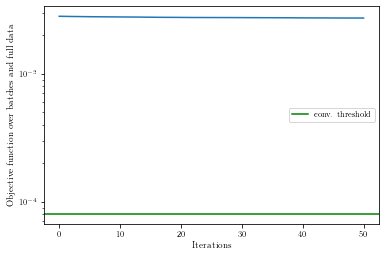

#################
	 Convergence criterion not satisfied, try increasing max_iter or using new initializations.
	 Final objective function value 0.0027186919669044012 with # of initializations: 1 
 	 Total runtime: 159.40292811393738


In [10]:
bsize = 120   # The batch size on which the optimization is started
results = []
rK = 16
for _ in range(1):  
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    K,X,E,rho,res_list = algorithm.run_mGST(y_all, J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'GD',
                         max_inits = 1, max_iter = 0, final_iter = 50, threshold_multiplier = 5, 
                         target_rel_prec = 1e-5,  fixed_elements = [], init = [K, E, rho], testing = True)   
    # K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
    #                      max_inits = 10, max_iter = 0, final_iter = 30, threshold_multiplier = 500, 
    #                      target_rel_prec = 1e-4, init = [K,E,rho], testing = True)   
    results.append([K,X,E,rho])

In [11]:
# ###################################### 
# filename = 'rank_16_hardware_probs_1132'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[16],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J_all,'y':y_all, 'target_rel_prec':1e-5}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

## Simulated probabilities

### Rank 2

In [6]:
with open("rank_2_simulated_probs_1132", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [7]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99937","0,00256"
Rx(pi/2)[q0],"0,99963","0,00222"
Ry(pi/2)[q0],"0,99941","0,00207"
Rx(pi/2)[q1],"0,99946","0,00192"
Ry(pi/2)[q1],"0,99927","0,00308"
CZ[q0-q1],"0,99895","0,00334"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.023542,0.212446,0.213159,0.000829,0.000934


(None, None)

## Hardware probabilities

### Full rank

In [14]:
with open("rank_16_hardware_probs_1132", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [15]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 100}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99986","0,01865","0,01472"
Rx(pi/2)[q0],"0,99520","0,10204","0,05226"
Ry(pi/2)[q0],"0,99372","0,11378","0,06438"
Rx(pi/2)[q1],"0,98843","0,14611","0,11122"
Ry(pi/2)[q1],"0,98887","0,14735","0,10169"
CZ[q0-q1],"0,34534","0,97798","0,91280"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002719,0.059646,0.213159,0.139301,0.026874


(None, None)

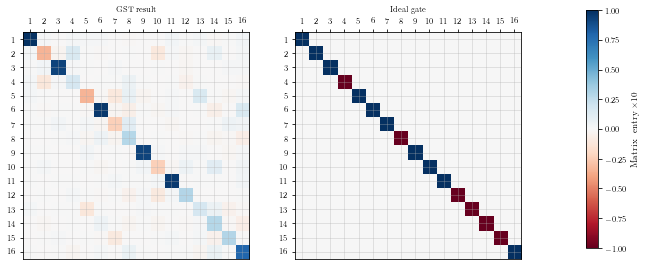

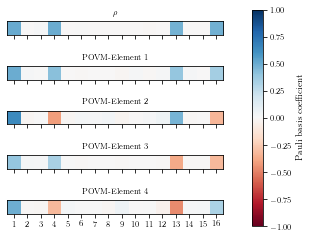

In [16]:
gate_index = 5

X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt,E_opt,rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'pp')


plot_mat(X_opt[gate_index], X_t[gate_index])
plot_spam(rho_opt_pp, E_opt_pp)

Assignment fidelity for ideal basis state 0: 0.6672378401664638


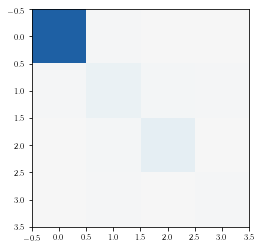

Assignment fidelity for ideal basis state 1: 0.8571830958921447


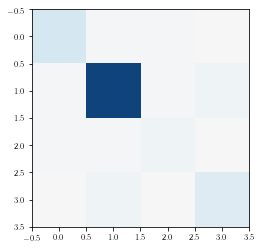

Assignment fidelity for ideal basis state 2: 0.49695138074204726


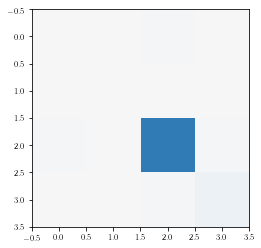

Assignment fidelity for ideal basis state 3: 0.6407400837419284


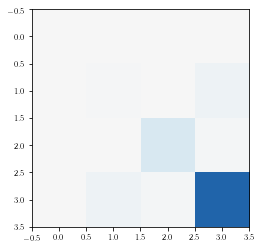

In [17]:
for i in range(4):
    print("Assignment fidelity for ideal basis state %i:"%i, np.abs(E_opt.reshape(4,4,4)[i,i,i])**2)
    plt.imshow(np.abs(E_opt.reshape(4,4,4)[i,:,:]), vmin = -1, vmax = 1)
    plt.show()

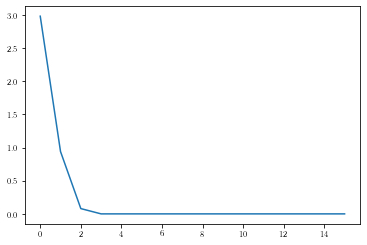

In [14]:
# Spectrum of the Choi matrix
X_choi = X_opt.reshape(d,pdim,pdim,pdim,pdim)
X_choi = np.einsum('ijklm->iljmk',X_choi).reshape(d,pdim**2,pdim**2)
plt.plot(np.sort(np.abs(la.eig(X_choi[5])[0]))[::-1])

In [18]:
from qiskit.quantum_info import entanglement_of_formation

plus_plus = np.outer(np.array([1,1,1,1])/2,np.array([1,1,1,1])/2).reshape(-1)

print(entanglement_of_formation((X_opt[5]@plus_plus).reshape(4,4)))

0.012591550652701854


#### CHSH value

In [29]:
#Ideal CZ
plus_plus = np.outer(np.array([1,1,1,1])/2,np.array([1,1,1,1])/2).reshape(-1)
rho_ent = X_t[5]@plus_plus
rho_ent_pp = compatibility.std2pp(X,E,rho_ent)[2].reshape(4,4)
T_rho = 2*rho_ent_pp[1:,1:]
eigs = np.sort(la.eig(T_rho.T@T_rho)[0])
CHSH = 2*np.sqrt(eigs[0] + eigs[1])
print(CHSH)

(2.8284271247461907+0j)


In [28]:
#Reconstructed gate
plus_plus = np.outer(np.array([1,1,1,1])/2,np.array([1,1,1,1])/2).reshape(-1)
rho_ent = X[5]@plus_plus
rho_ent_pp = compatibility.std2pp(X,E,rho_ent)[2].reshape(4,4)
T_rho = 2*rho_ent_pp[1:,1:]
eigs = np.sort(la.eig(T_rho.T@T_rho)[0])
CHSH = 2*np.sqrt(eigs[0] + eigs[1])
print(CHSH)

(0.781627429623273+0j)


### Rank 4

In [34]:
with open("rank_4_hardware_probs_1132", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [35]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 100}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,97591","0,06193","0,03529"
Rx(pi/2)[q0],"0,97197","0,13688","0,07129"
Ry(pi/2)[q0],"0,97657","0,12613","0,07207"
Rx(pi/2)[q1],"0,96946","0,14748","0,12124"
Ry(pi/2)[q1],"0,96595","0,17581","0,11371"
CZ[q0-q1],"0,36707","0,96014","0,95075"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002555,0.058268,0.213159,0.102361,0.014076


(None, None)

### Rank 4 with fixed Identity and initial state

In [36]:
with open("rank_4_hardware_probs_1132_G0_and_rho_fixed", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [38]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 100}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"1,00000","0,00000","0,00000"
Rx(pi/2)[q0],"0,96913","0,15921","0,07040"
Ry(pi/2)[q0],"0,97528","0,13160","0,07527"
Rx(pi/2)[q1],"0,96816","0,14740","0,12198"
Ry(pi/2)[q1],"0,96534","0,17936","0,11595"
CZ[q0-q1],"0,38085","0,92268","0,95216"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002600,0.058592,0.213159,0.098857,0.002373


(None, None)

### Rank 1

In [59]:
with open("rank_1_hardware_probs_1132", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [109]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 10}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99920","0,03915","0,03477"
Rx(pi/2)[q0],"0,99386","0,11484","0,07295"
Ry(pi/2)[q0],"0,20002","1,00000","0,05822"
Rx(pi/2)[q1],"0,99089","0,14396","0,09342"
Ry(pi/2)[q1],"0,98704","0,16423","0,11822"
CZ[q0-q1],"0,27213","0,99964","0,44911"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006403,0.089876,0.213159,0.185020,0.036067


(None, None)

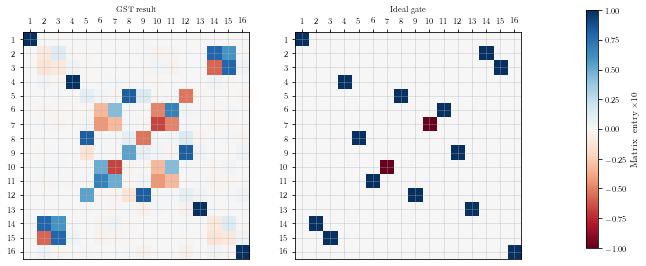

In [61]:
X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt,E_opt,rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'pp')
plot_mat(X_opt_pp[5], X_t_pp[5])

In [103]:
from scipy.linalg import expm
s0 = np.array([[1,0],[0,1]]).astype(np.complex128)
s1 = np.array([[0,1],[1,0]]).astype(np.complex128)
s2 = np.array([[0,-1j],[1j,0]]).astype(np.complex128)
s3 = np.array([[1,0],[0,-1]]).astype(np.complex128)
g_phase = np.array([[1,0],[0,np.exp(-1j*np.pi/2)]]).astype(np.complex128)
CNOT = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]]).astype(np.complex128)
Rxy = expm(1j*np.pi*(s1+s2))

unitary_part = np.kron(s2,s0)
K_XI = np.array([unitary_part])
X_XI = np.einsum('jkl,jnm -> knlm', K_XI, K_XI.conj()).reshape(16,16)

rho_test = X_XI@rho_opt
E_test = E_opt@X_XI.T.conj()

X_test = np.einsum('ij,kjl, lm -> kim', X_XI.T.conj(), X_opt, X_XI)

In [119]:
pdim = int(np.sqrt(rho.shape[0]))
mdl = compatibility.arrays_to_pygsti_model(X,E,rho, basis = 'std')
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'std')
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

gauge_optimized_mdl = gaugeopt_to_target(mdl, 
            target_mdl,gauge_group = gaugegroup.FullGaugeGroup(target_mdl.state_space),
            item_weights=weights)

In [120]:
X_test, E_test, rho_test = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std') 

In [121]:
test_mdl = compatibility.arrays_to_pygsti_model(X_test,E_test,rho_test, basis = 'std')
print(compatibility.average_gate_fidelities(test_mdl,target_mdl,pdim, basis_string = 'pp'))

[0.99919946 0.99620165 0.99616165 0.99247263 0.98894793 0.5449956 ]


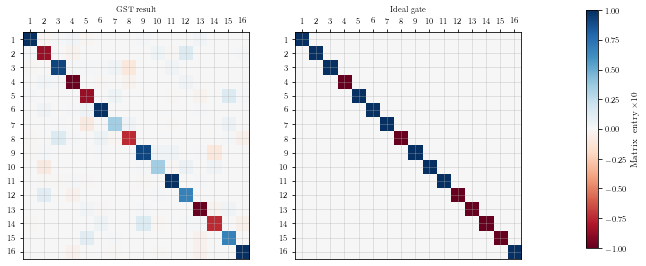

In [122]:
plot_mat(X_test[5], X_t[5])

Assignment fidelity for ideal basis state 0: 0.7643713161290673


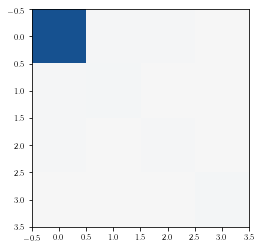

Assignment fidelity for ideal basis state 1: 1.0484394703947253


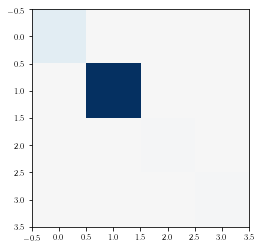

Assignment fidelity for ideal basis state 2: 0.9461944564246598


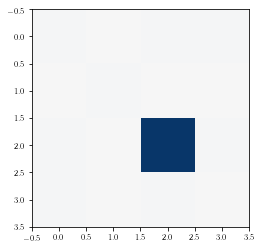

Assignment fidelity for ideal basis state 3: 0.9839489640209645


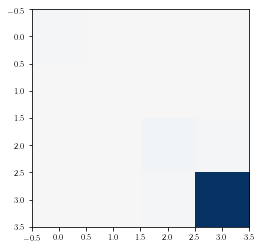

In [123]:
for i in range(4):
    print("Assignment fidelity for ideal basis state %i:"%i, np.abs(E_test.reshape(4,4,4)[i,i,i])**2)
    plt.imshow(np.abs(E_test.reshape(4,4,4)[i,:,:]), vmin = -1, vmax = 1)
    plt.show()

### Rank 1 with fixed Identity and initial state

In [42]:
with open("rank_1_hardware_probs_1132_G0_and_rho_fixed", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [43]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 100}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"1,00000","0,00000","0,00000"
Rx(pi/2)[q0],"0,99331","0,12269","0,06238"
Ry(pi/2)[q0],"0,99153","0,13815","0,07505"
Rx(pi/2)[q1],"0,99027","0,13922","0,10397"
Ry(pi/2)[q1],"0,98836","0,15125","0,10372"
CZ[q0-q1],"0,23410","1,00000","0,68958"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004157,0.075736,0.213159,0.201297,0.002440


(None, None)

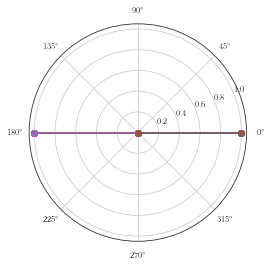

In [20]:
for x in np.diag(X_t[5]):
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()

## Gauge testing

In [99]:
with open("rank_16_hardware_probs_1132", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [100]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 100}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99977","0,02118"
Rx(pi/2)[q0],"0,99496","0,09828"
Ry(pi/2)[q0],"0,99469","0,10269"
Rx(pi/2)[q1],"0,98928","0,14945"
Ry(pi/2)[q1],"0,97613","0,16390"
CZ[q0-q1],"0,34180","0,96030"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002984,0.060981,0.213159,0.127179,0.023828


(None, None)

### Checking if local phases gates (not a gauge transformation) can bring the reconstructed gate into a CZ gate

In [ ]:
def X_1q_phases(phi1,phi2):
    R1 = np.array([[1,0],[0, np.exp(1j*phi1)]]).astype(np.complex128)
    R2 = np.array([[1,0],[0, np.exp(1j*phi2)]]).astype(np.complex128)
    R12 = np.kron(R1,R2)
    K = np.array([R12])
    X = np.einsum('jkl,jnm -> knlm', K, K.conj()).reshape(16,16) 
    return X

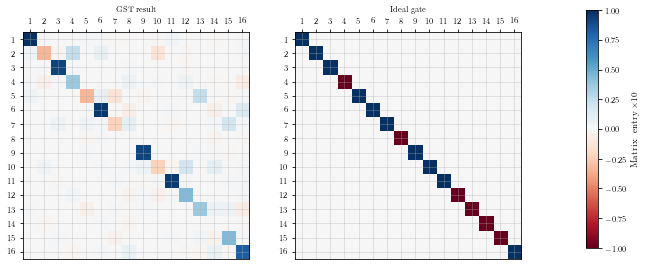

In [ ]:
plot_mat(X_opt[5],X_t[5])

In [ ]:
def cost(args, X, X_t):
    phi1 = args[0]
    phi2 = args[1]
    X_rot = X_1q_phases(phi1, phi2)
    X_test = X@X_rot
    return la.norm(X_t-X_test)

(100, 100)


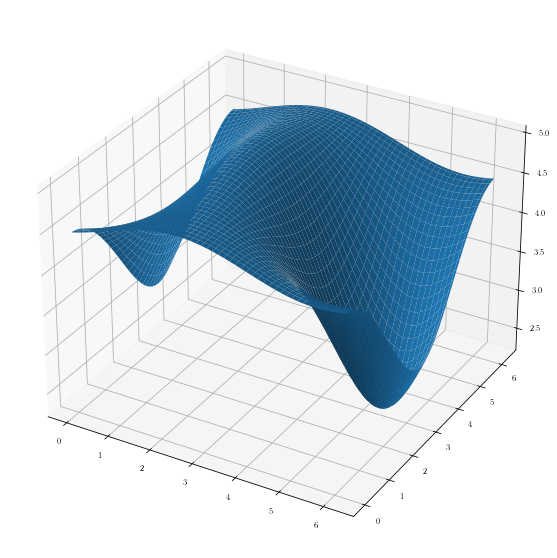

In [ ]:
phi1_vals = np.pi*np.arange(10)/10
phi1_vals = np.pi*np.arange(10)/10

X_vals = 2*np.pi*np.arange(100)/100
Y_vals = 2*np.pi*np.arange(100)/100
Z_vals = np.array([[cost([phi1, phi2], X_opt[5], X_t[5]) for phi1 in X_vals] for phi2 in Y_vals])
print(Z_vals.shape)
X_vals, Y_vals = np.meshgrid(X_vals, Y_vals)

fig, ax = plt.subplots(figsize = (10,10), subplot_kw={"projection": "3d"})
ax.plot_surface(X_vals,Y_vals,Z_vals)
plt.show()

In [ ]:
from scipy.optimize import minimize
res = minimize(cost, np.array([0,0]), args = (X_opt[5],X_t[5]))
x = res.x
print(res.x/np.pi)

[-0.29227836  1.01546921]


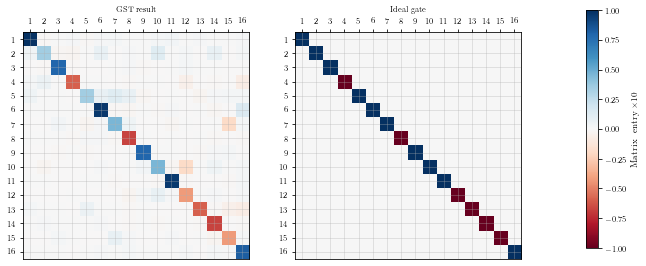

In [ ]:
phi1 = x[0]
phi2 = x[1]
X_rot = X_1q_phases(phi1, phi2)
X_test = X_opt[5]@X_rot
plot_mat(X_test, X_t[5])